In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import locale

Datenaufbereitung


In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "email", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [3]:
df_reg_main.head()

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,email,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,friedhilde.kuhl@yahoo.de,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,heide-marie.fischer@gmx.de,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,ester.pruschke@gmail.com,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,klaus.blümel@aol.de,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,waldemar.fritsch@web.de,A,online


In [23]:
# Create a custom formatter function for the y-axis
def millions_formatter(x, pos):
    return "%1.f Mio." % (x * 1e-6)

# Generic formatting for lineplot
def format_lineplot():
    # Define the plot size
    # plt.figure(figsize=(10, 6))

    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.utf8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    plt.gca().xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    plt.xticks(rotation=45)

    # Set the starting point of the y-axis to 0
    plt.gca().set_ylim(bottom=0)
    
    # Remove the y-axis and x-axis label
    plt.gca().set_ylabel("")
    plt.gca().set_xlabel("")

    # Add grid lines for better readability
    plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

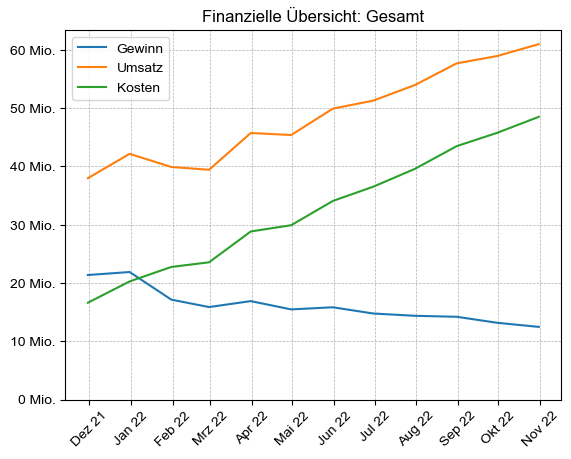

In [27]:
df = df_reg_main.groupby(pd.Grouper(key="date", freq="1M")).agg(
    {"profit": "sum", "revenue": "sum", "cost": "sum"}
)

sns.lineplot(data=df, x="date", y="profit", label="Gewinn")
sns.lineplot(data=df, x="date", y="revenue", label="Umsatz")
sns.lineplot(data=df, x="date", y="cost", label="Kosten")

format_lineplot()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.title("Finanzielle Übersicht: Gesamt")

plt.show()

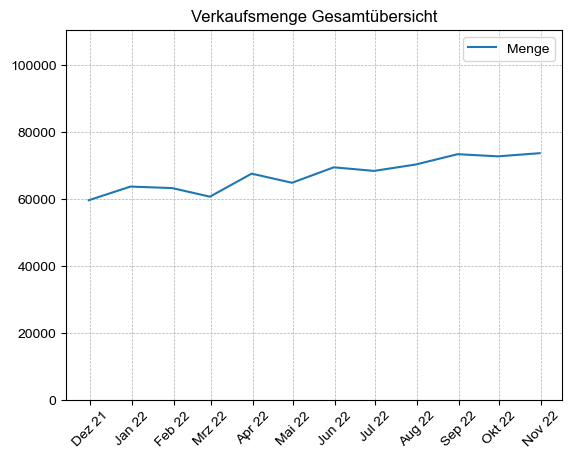

In [30]:
df = df_reg_main.groupby(pd.Grouper(key="date", freq="1M")).agg({"amount": "sum"})

sns.lineplot(data=df, x="date", y="amount", label="Menge")

format_lineplot()

# Dynamically set the y-axis upper limit to be slightly above the max value
max_amount = df["amount"].max()
plt.gca().set_ylim(top=max_amount + max_amount * 0.5)

plt.title("Verkaufsmenge Gesamtübersicht")

plt.show()

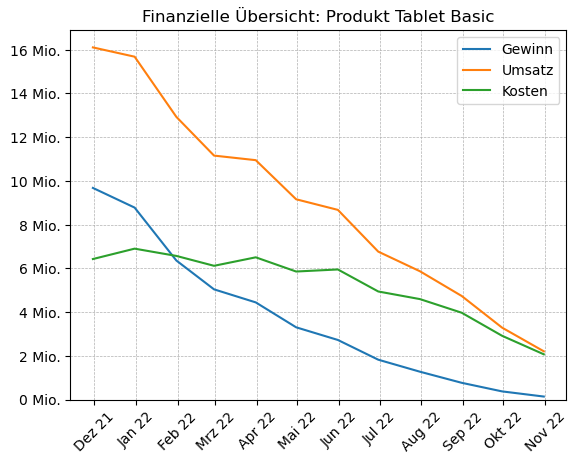

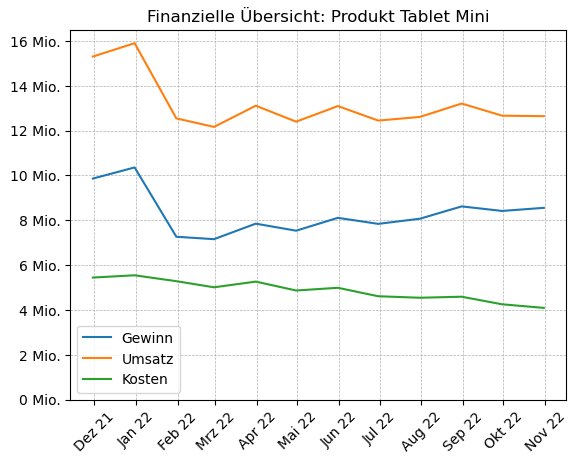

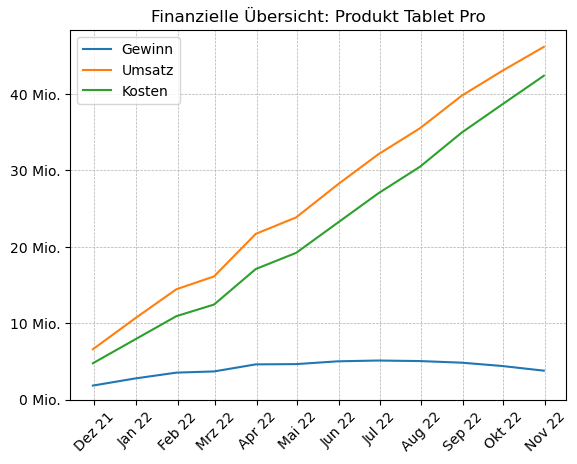

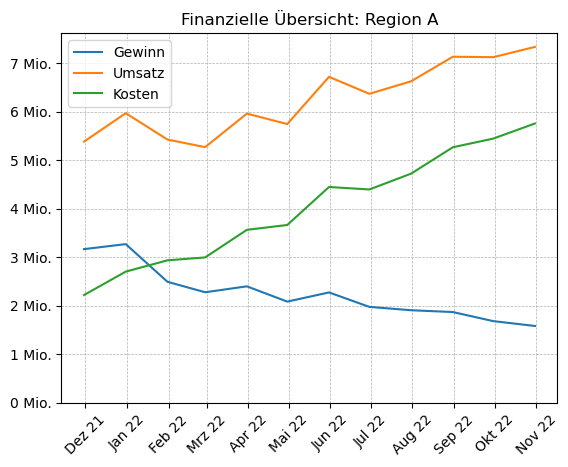

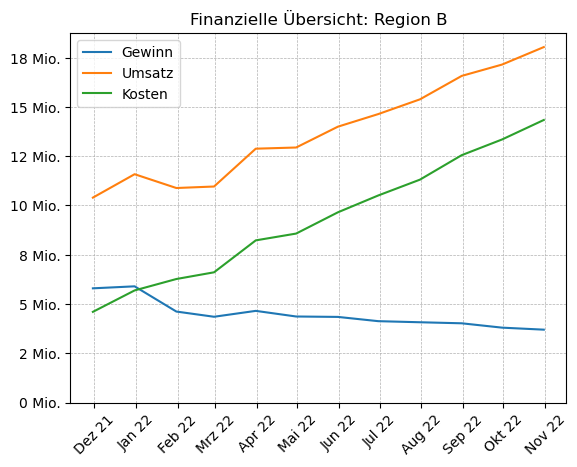

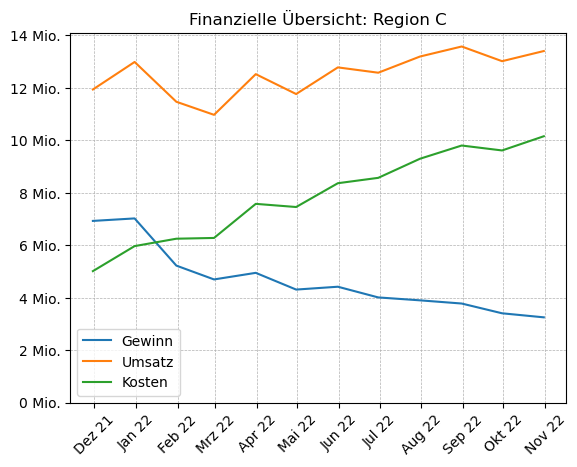

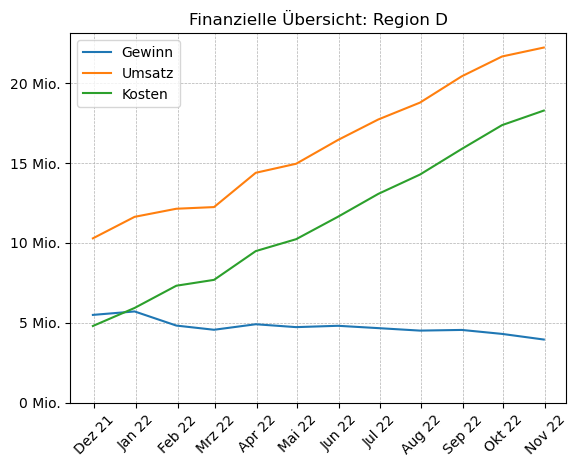

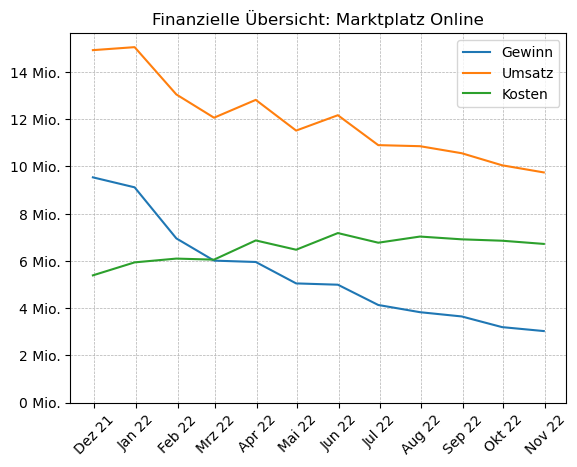

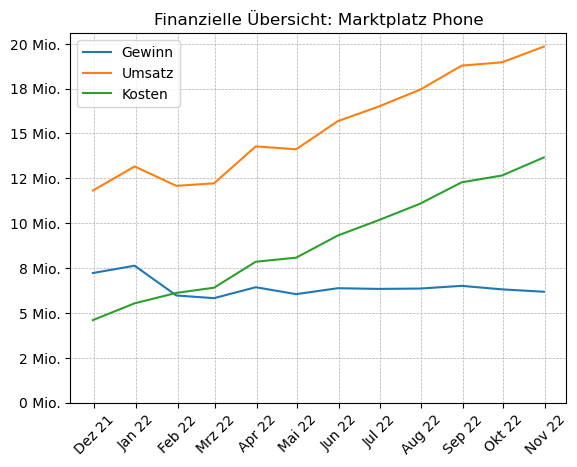

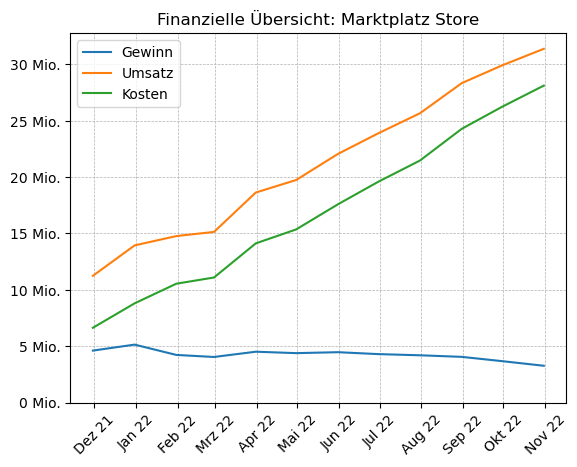

In [7]:
groups = {"product": "Produkt", "region": "Region", "marketplace": "Marktplatz"}

for group_key, group_label in groups.items():
    # Get the unique group_items (e.g. Product A, Product B, etc.)
    group_items = df_reg_main[group_key].unique()

    for group_item in group_items:
        # Filter the DataFrame for the current product
        df_group = df_reg_main[df_reg_main[group_key] == group_item]

        # Group and sum the data for the current product
        df_grouped = (
            df_group.groupby(pd.Grouper(key="date", freq="1M"))
            .agg({"profit": "sum", "revenue": "sum", "cost": "sum"})
            .reset_index()
        )

        sns.lineplot(data=df_grouped, x="date", y="profit", label="Gewinn")
        sns.lineplot(data=df_grouped, x="date", y="revenue", label="Umsatz")
        sns.lineplot(data=df_grouped, x="date", y="cost", label="Kosten")

        # Generic formatting
        format_lineplot()

        # Apply millions_formatter to the y-axis
        plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

        plt.title(f"Finanzielle Übersicht: {group_label} {group_item.title()}")

        plt.show()

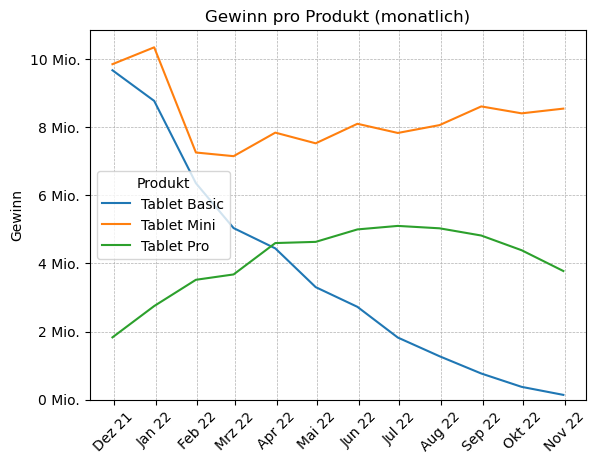

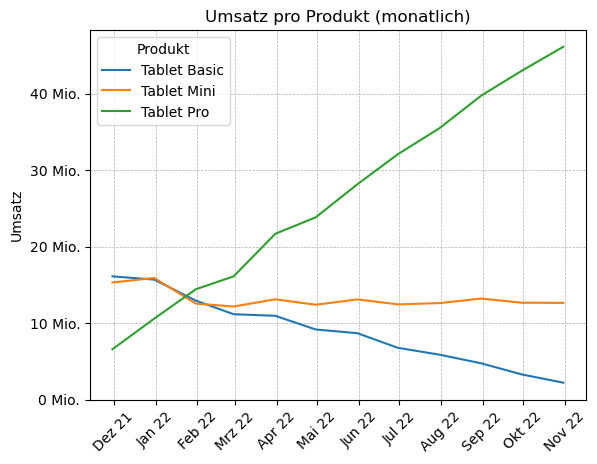

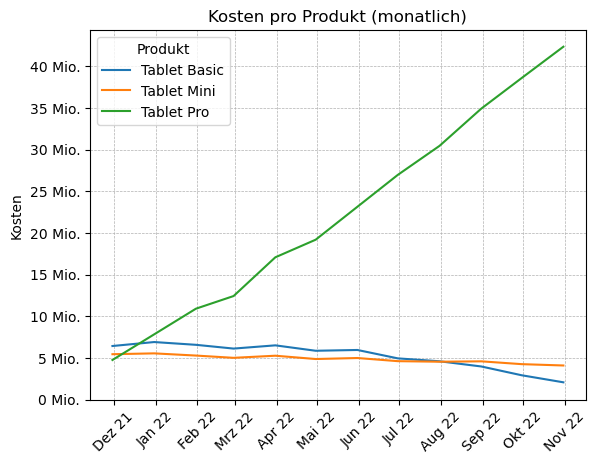

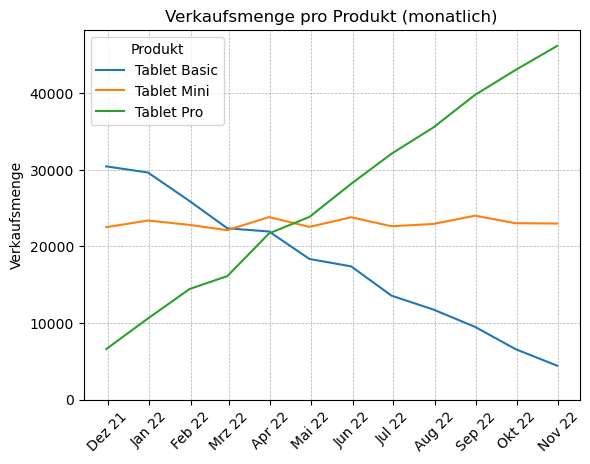

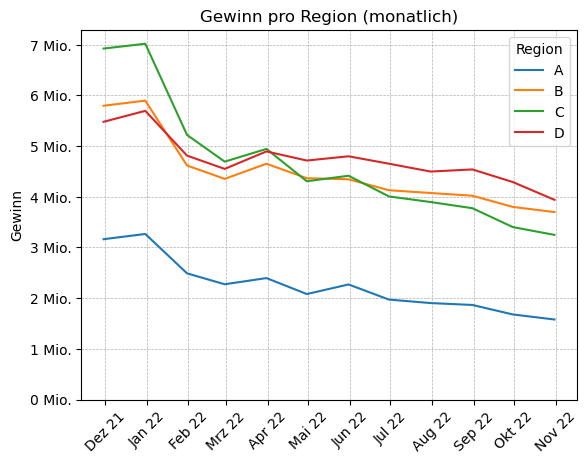

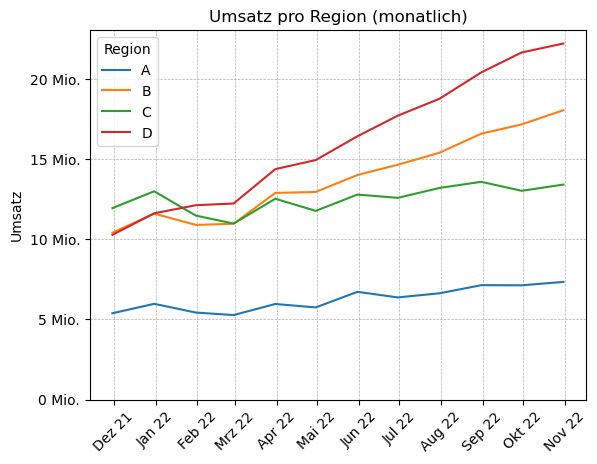

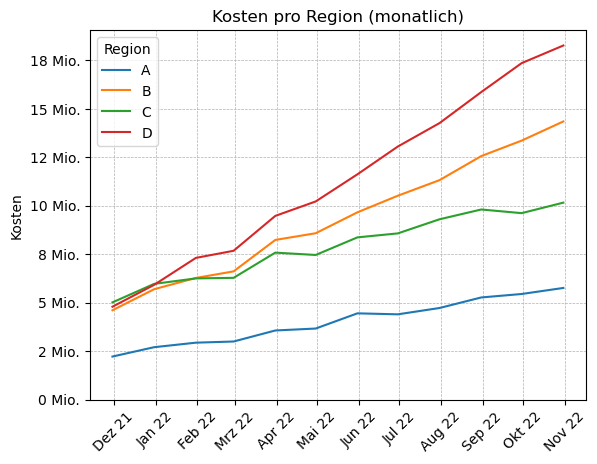

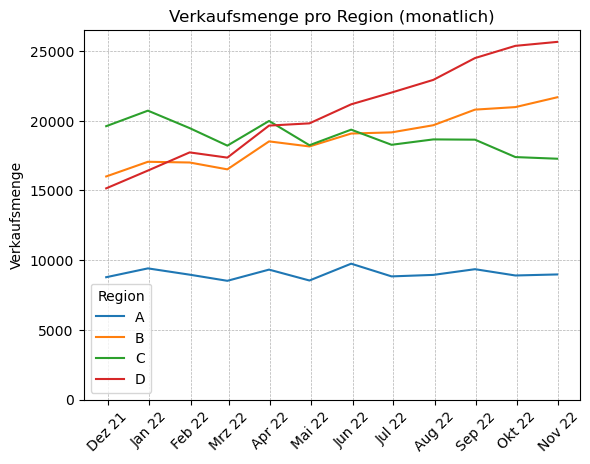

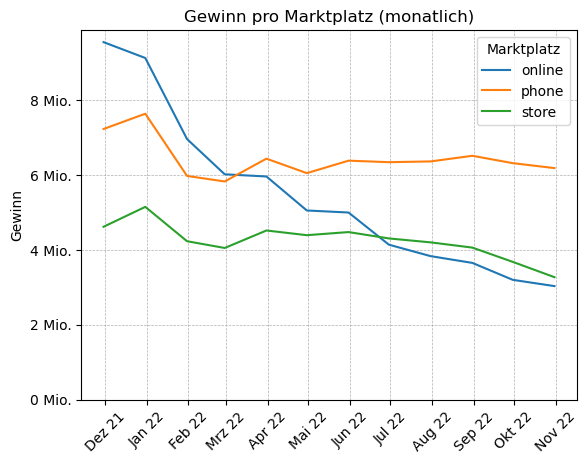

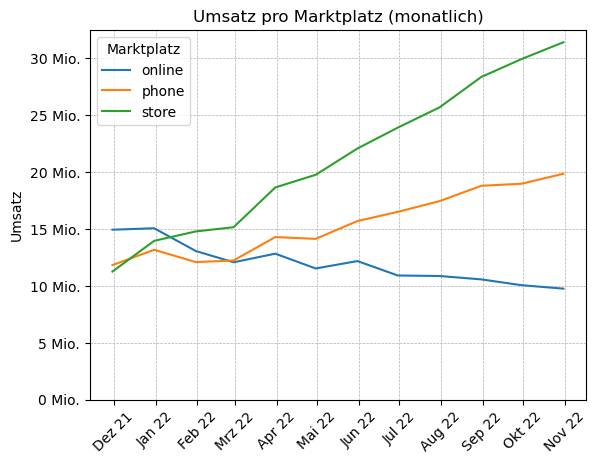

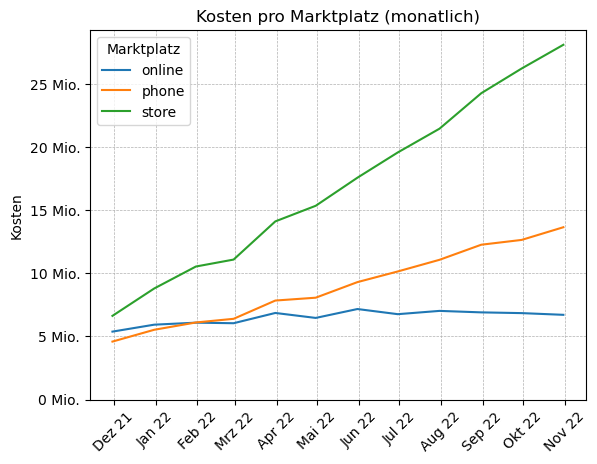

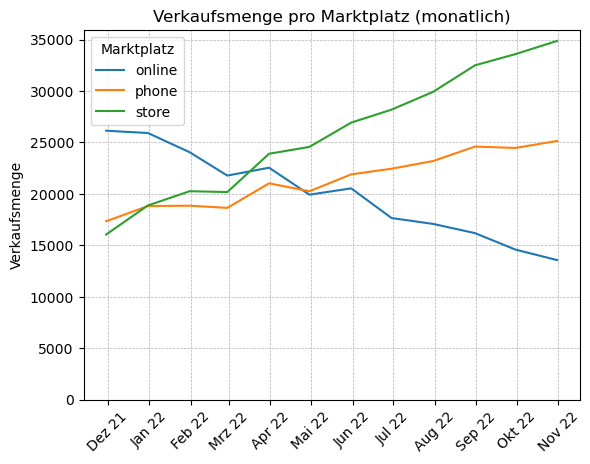

In [8]:
groups = {"product": "Produkt", "region": "Region", "marketplace": "Marktplatz"}
metrics = {
    "profit": "Gewinn",
    "revenue": "Umsatz",
    "cost": "Kosten",
    "amount": "Verkaufsmenge",
}

for group_key, group_label in groups.items():
    # Get the unique group_items (e.g. Product A, Product B, etc.)
    group_items = df_reg_main[group_key].unique()

    for metric_key, metric_label in metrics.items():
        for group_item in group_items:
            # Filter the DataFrame for the current product
            df_group = df_reg_main[df_reg_main[group_key] == group_item]

            # Group and sum the data for the current group by month
            df_grouped = (
                df_group.groupby([pd.Grouper(key="date", freq="1M"), group_key])
                .agg({metric_key: "sum"})
                .reset_index()
            )

            # Plot the line with a label for the legend, identifying each group's metric over time
            sns.lineplot(
                data=df_grouped,
                x="date",
                y=metric_key,
                label=f"{group_item}",
                # label=f"{group_item} - {metric_label}",
            )

        # Generic formatting
        format_lineplot()

        if metric_key != "amount":
            plt.gca().yaxis.set_major_formatter(
                ticker.FuncFormatter(millions_formatter)
            )

        # Add a legend to the plot
        plt.legend(title=group_label)

        # Set the ylabel to the metric label
        plt.gca().set_ylabel(metric_label)

        # Set the title of the plot to reflect the metric being plotted
        plt.title(f"{metric_label} pro {group_label} (monatlich)")

        # Show the plot
        plt.show()